In [3]:
import os
from tqdm import tqdm
import pandas as pd
import urllib.request
from math import floor
import sys
from joblib import Parallel, delayed

class ImageDownloader:
    def __init__(self, loader_root):
        self.loader_root = loader_root
        self.csv_remote_path = 'https://raw.githubusercontent.com/NationalGalleryOfArt/opendata/main/data/'

    def ensure_exists(self, path, image=False):
        if not os.path.exists(path):
            os.makedirs(path)
        elif os.listdir(path) and image:
            # Prevent downloading images in a non-empty folder
            raise OSError(f"The folder '{path}' is not empty.")

    def get_base_dir(self):
        self.ensure_exists(self.loader_root)
        self.ensure_exists(f"{self.loader_root}/annotations")
        self.ensure_exists(f"{self.loader_root}/images",True)
        return self.loader_root

    def thumbnail_to_local(self, base_path, object_id):
        image_path = f"{base_path}/images"
        ending = f"{object_id}.jpg"
        return f"{image_path}/{ending}"

    def get_file(self, remote_url, out, timeout_seconds=10):
        with urllib.request.urlopen(remote_url, timeout=timeout_seconds) as response:
            with open(out, "wb") as out_file:
                data = response.read()  # a `bytes` object
                out_file.write(data)

    def check_csv_exists(self,csv_name,base_dir=None):
        base_dir = base_dir or self.get_base_dir()
        csv_path = f"{base_dir}/annotations/{csv_name}.csv"
        if not os.path.exists(csv_name):
                self.get_file(self.csv_remote_path+f'/{csv_name}.csv', out=csv_path, timeout_seconds=100)
                print(f"{csv_name}.csv file download successful")
        return csv_path

    def download_painting(self, base_dir=None, percent=100):
        print("Downloading data...")
        base_dir = base_dir or self.get_base_dir()
        objects_csv = self.check_csv_exists('objects')
        objects_df = pd.read_csv(objects_csv)

        published_images_csv = self.check_csv_exists('published_images')
        images_df = pd.read_csv(published_images_csv)

        # Merge and filter DataFrames
        painted_df = self.merge_and_filter(objects_df, images_df,base_dir)
        samples = floor(painted_df.shape[0] * (percent / 100))
        painted_df = painted_df.head(samples)

        def download_image(object_id,thumb):
            out = self.thumbnail_to_local(base_dir,object_id)
            if os.path.exists(out):
                 return
            try:
                self.get_file(thumb, out=out)
            except Exception as e:
                print(e)
                print(f"failed to get {thumb}")

        print(f"Found {painted_df['objectid'].nunique()} images.")

        Parallel(n_jobs=16)(delayed(download_image)(object_id, thumb) for object_id, thumb in tqdm(painted_df[['objectid', 'iiifthumburl']].values, leave=False))

        existing_files = os.listdir( os.path.join(self.loader_root,'images'))
        existing_objectids = [int(filename.split('.')[0]) for filename in existing_files]
        missing_objectids = set(painted_df['objectid']) - set(existing_objectids)
        painted_df = painted_df[~painted_df['objectid'].isin(missing_objectids)]
        painted_df.to_csv('./data/merged.csv', index=False)
        print(f"{len(missing_objectids)} rows with URL error are dropped")
        print(f"{len(painted_df['objectid'])} images download completed")

    def merge_and_filter(self, objects_df, images_df, output_file):
        painted_df = pd.merge(
            objects_df[['objectid', 'title', 'attribution', 'classification']],
            images_df[['depictstmsobjectid', 'iiifthumburl']],
            left_on='objectid', right_on='depictstmsobjectid',
            how='inner'
        )

        painted_df = painted_df.drop_duplicates().drop('depictstmsobjectid', axis=1)

        return painted_df

In [4]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class ImageDataset(Dataset):

    def __init__(self, dataFrame, image_dir="./data/images", transform=None):
        self.dataFrame = dataFrame
        self.image_dir = image_dir
        self.transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Resize((200,200)),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, str(self.dataFrame.iloc[idx]['objectid'])+'.jpg')
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return image

    def __len__(self):
        return len(self.dataFrame)

In [5]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from facenet_pytorch import MTCNN
from torchvision.transforms.functional import to_pil_image
from torchvision.models import VGG16_Weights, ResNet50_Weights

class ResNetCompressor():
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', weights=ResNet50_Weights.DEFAULT)
        self.extractor = torch.nn.Sequential(*list(self.model.children())[:-2]).to(device)

    def extract(self, image_tensor):
        with torch.no_grad():
            features = self.extractor(image_tensor.to(self.device))
        return features.view(features.size(0), -1)

class FaceCropper():
    def __init__(self, compressor, device='cpu'):
        self.compressor = compressor
        self.device = device
        self.face_detector = MTCNN(min_face_size=2,margin=10,thresholds = [0.6, 0.6, 0.6],device = device,keep_all=True,post_process=True)
        self.face_detector.eval()

    def crop_faces(self, image_tensor):
        cropped_images = []
        for img in image_tensor:
            pil_img = to_pil_image(img)
            boxes, _ = self.face_detector.detect(pil_img)

            if boxes is not None and len(boxes) > 0:
                valid_boxes = []
                for box in boxes:
                    x_min, y_min, x_max, y_max = map(int, box)
                    x_min, y_min, x_max, y_max = [max(0, val) for val in [x_min, y_min, x_max, y_max]]

                    if x_max > x_min and y_max > y_min:
                        valid_boxes.append((x_min, y_min, x_max, y_max))

                if len(valid_boxes) > 0:
                    x_min = min(box[0] for box in valid_boxes)
                    y_min = min(box[1] for box in valid_boxes)
                    x_max = max(box[2] for box in valid_boxes)
                    y_max = max(box[3] for box in valid_boxes)

                    cropped_img = img[:, y_min:y_max, x_min:x_max]

                    resized_img = torch.nn.functional.interpolate(cropped_img.unsqueeze(0), size=(200, 200), mode='bilinear', align_corners=False)
                    cropped_images.append(resized_img.squeeze(0))
            else:
                x_min, y_min, x_max, y_max = 0, 0, 200, 200
                cropped_img = img[:, y_min:y_max, x_min:x_max]
                cropped_images.append(cropped_img)

        stacked_tensor = torch.stack(cropped_images).to(self.device)

        extracted_features = self.compressor.extract(stacked_tensor)

        return extracted_features

In [6]:
import os
import torch
import numpy as np
from PIL import Image
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.neighbors import NearestNeighbors
from torchvision.transforms import transforms
import pickle

class ImageRetrieval:
    def __init__(self, compressor, img_path, k=5, face_crop=False, device='cpu'):
        self.compressor = compressor
        self.compressor.device = device
        self.merged_df = pd.read_csv('./data/merged.csv')
        self.img_path = img_path
        self.device = device
        self.k = k

        pickle_file = "features.pkl"
        if os.path.exists(pickle_file) and os.path.getsize(pickle_file) > 0: # Check if the file exists and is not empty
            with open(pickle_file, "rb") as f:
                self.features, self.image_paths = pickle.load(f)
            print(f"Loaded features from {pickle_file}")
        else:
            print(f"features.pkl is empty or does not exist. Extracting features...")
            self.features, self.image_paths = self.extract_features(face_crop)

    def extract_features(self, face_crop=False, save_interval=100000):
      pickle_file = "features.pkl"
      if os.path.exists(pickle_file):
          with open(pickle_file, "rb") as f:
              features, image_paths = pickle.load(f)

          total_images = len(self.merged_df)

          if len(image_paths) == total_images:
              print(f"Loaded features from {pickle_file}. Feature extraction is already complete.")
              return features, image_paths
          else:
              print(f"Loaded features for {len(image_paths)} images from {pickle_file}. Resuming feature extraction.")
              start_index = len(image_paths)
      else:
          features = []
          image_paths = []
          start_index = 0

      image_dataset = ImageDataset(self.merged_df)
      data_loader = DataLoader(image_dataset, batch_size=32, shuffle=False)

      if face_crop:
          face_cropper = FaceCropper(self.compressor, device=self.device)

      print('Building Feature Vector List')
      for i, image_tensors in enumerate(tqdm(data_loader, total=len(data_loader), initial=start_index // data_loader.batch_size)):
          if i < start_index // data_loader.batch_size:
              continue

          if face_crop:
              extracted_features = face_cropper.crop_faces(image_tensors)
          else:
              extracted_features = self.compressor.extract(image_tensors.to(self.device))

          extracted_features = extracted_features.view(extracted_features.size(0), -1).cpu().numpy()
          features.extend(extracted_features)
          image_paths.extend(image_dataset.dataFrame.iloc[len(features) - len(extracted_features):len(features)]['objectid'].tolist())

          if len(image_paths) % save_interval == 0:
              with open(pickle_file, "wb") as f:
                  pickle.dump((features, image_paths), f)
              print(f"Saved progress to {pickle_file}")

      return features, image_paths

    def retrieve_similar_images(self, query_image_path, metric='cosine',face_crop=False):
        self.transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Resize((200,200)),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])
        image = Image.open(query_image_path).convert("RGB")
        query_image_tensor = self.transform(image).unsqueeze(0).to(self.device)

        if face_crop:
            face_cropper = FaceCropper(self.compressor,device=self.device)
            query_features = face_cropper.crop_faces(query_image_tensor)
            if query_features is None:
                    query_features = self.compressor.extract(query_image_tensor)
        else:
            query_features = self.compressor.extract(query_image_tensor)

        query_object_id = os.path.basename(query_image_path).split(".")[0]
        query_index = self.merged_df[self.merged_df['objectid'] == int(query_object_id)].index.tolist()[0]
        except_query = np.delete(self.features, query_index+1, axis=0)

        knn = NearestNeighbors(n_neighbors=self.k, metric=metric)
        knn.fit(except_query)

        query_features = query_features.cpu().numpy()
        distances, indices = knn.kneighbors(query_features)
        similar_images = [(self.image_paths[i], distances[0, j]) for j, i in enumerate(indices[0])]
        similar_images = similar_images[1:]  # Skip the first element (query image)
        similar_images.sort(key=lambda x: x[1])  # Sort the similar images by distance

        return similar_images

In [7]:
import os
import numpy as np
from PIL import Image
import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from skimage.transform import resize

class evaluation_metrics:
    def __init__(self,img_path):
        self.img_path = img_path

    def visualize_images(self, similar_images_paths, query_image_path):
        query_image = Image.open(query_image_path)

        fig, axes = plt.subplots(1, len(similar_images_paths) + 1, figsize=(15, 5))
        axes[0].imshow(query_image)
        axes[0].set_title("Query Image")
        axes[0].axis('off')

        for i, (file_name, distance) in enumerate(similar_images_paths, start=1):
            image = Image.open(os.path.join(self.img_path, str(file_name)+'.jpg'))
            axes[i].imshow(image)
            axes[i].set_title(f'Similar Image {i} ({file_name})')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show();


    def eval_results(self,query_image_path, similar_images_paths):
        query_image = np.array(Image.open(query_image_path).convert('RGB'))
        query_image = resize(query_image, (200, 200, 3))

        ssim_scores = []
        rmse_scores = []
        psnr_scores = []
        uqi_scores = []

        for (file_name,_) in similar_images_paths:
            img_path = os.path.join(self.img_path, str(file_name)+'.jpg')
            similar_image = np.array(Image.open(img_path).convert('RGB'))
            similar_image = resize(similar_image, (200, 200, 3))

            ssim_score, _ = ssim(query_image, similar_image, channel_axis=2, full=True,win_size=7,data_range=query_image.max() - query_image.min())
            ssim_scores.append(ssim_score)

            rmse_score = np.sqrt(mse(query_image, similar_image))
            rmse_scores.append(rmse_score)

        avg_ssim = np.mean(ssim_scores)
        avg_rmse = np.mean(rmse_scores)

        return avg_ssim, avg_rmse


In [8]:
import os
import random
import torch
import warnings
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from facenet_pytorch import MTCNN

warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) #check the device status

cpu


In [9]:
curr_path = os.getcwd()
loader_root = curr_path + "/data"
folder_path = './data/images'
percent = 15  

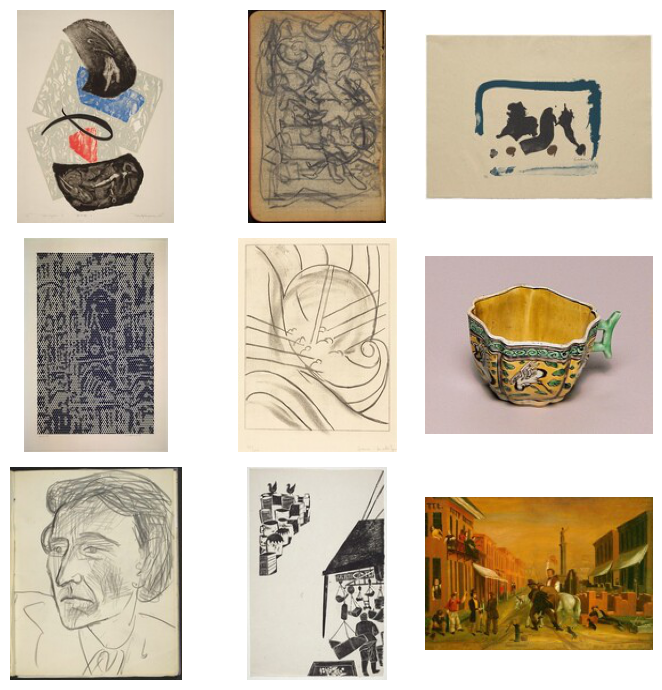

In [10]:
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
selected_images = random.sample(image_files, 9)

fig, axes = plt.subplots(3, 3, figsize=(7, 7))
for i, image_file in enumerate(selected_images):
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path)
    axes[i // 3, i % 3].imshow(img)
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

In [11]:
resnet = ResNetCompressor(device=device)
resnet_img_general = ImageRetrieval(resnet,folder_path,device=device)
# resnet_img_face = ImageRetrieval(resnet,folder_path,face_crop = True,device=device)

Using cache found in /Users/rushi_jani/.cache/torch/hub/pytorch_vision_v0.9.0


features.pkl is empty or does not exist. Extracting features...
Building Feature Vector List


100%|█████████████████████████████████████████| 570/570 [44:06<00:00,  4.64s/it]


In [14]:
eval = evaluation_metrics(folder_path)
metric = 'cosine' # You can change to other distance metrics

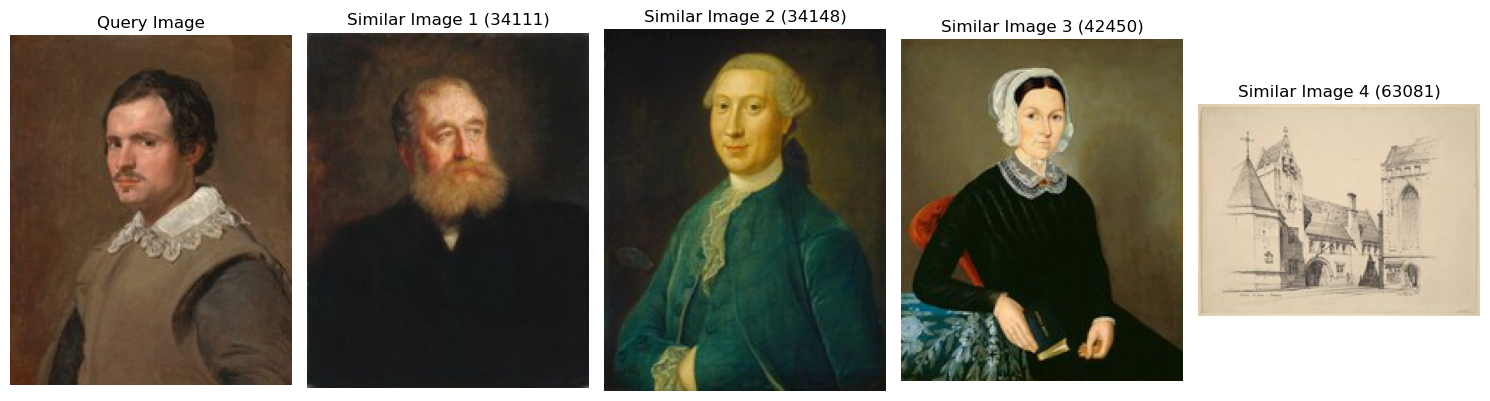

In [26]:
query_image1 = "./data/images/89.jpg"
similar_images1 = resnet_img_general.retrieve_similar_images(query_image1,metric)
eval.visualize_images(similar_images1,query_image1)

In [20]:
from tqdm import tqdm
image_files = os.listdir(folder_path)

results = []

for query_image in tqdm(image_files[:30], desc="Processing images"):
    query_image_path = os.path.join(folder_path, query_image)

    similar_images = {
        "resnet_general": resnet_img_general.retrieve_similar_images(query_image_path, metric),
    }

    for compressor, similar_images_set in similar_images.items():
        avg_ssim, avg_rmse = eval.eval_results(query_image_path, similar_images_set)
        results.append((compressor, avg_ssim, avg_rmse))

res = pd.DataFrame(results, columns=['Compressor', 'Average SSIM Score', 'Average RMSE Score'])
print(res)

Processing images: 100%|███████████████████████| 30/30 [58:53<00:00, 117.80s/it]


        Compressor  Average SSIM Score  Average RMSE Score
0   resnet_general            0.368535            0.236226
1   resnet_general            0.127036            0.278058
2   resnet_general            0.207195            0.275650
3   resnet_general            0.453209            0.160430
4   resnet_general            0.526355            0.187666
5   resnet_general            0.109614            0.317456
6   resnet_general            0.222711            0.342105
7   resnet_general            0.184229            0.248418
8   resnet_general            0.164941            0.257645
9   resnet_general            0.422728            0.156201
10  resnet_general            0.090472            0.261566
11  resnet_general            0.440599            0.348840
12  resnet_general            0.167166            0.330780
13  resnet_general            0.397552            0.250146
14  resnet_general            0.260656            0.251840
15  resnet_general            0.292993            0.2875

In [21]:
average_scores = res.groupby('Compressor').agg({'Average SSIM Score': 'mean', 'Average RMSE Score': 'mean'})

print(average_scores)

                Average SSIM Score  Average RMSE Score
Compressor                                            
resnet_general            0.244812            0.295753
